In [12]:
# Import the necessary libraries
import MDAnalysis as mda
import mdtraj as md
from MDAnalysis.analysis.distances import distance_array
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.analysis.base import AnalysisBase
from tqdm import tqdm

In [2]:
# Parameters used in the code
chain1 = 100 # Number of chains in the first protein MUT16
chain2 = 10 # Number of chains in the second protein MUT8
n_res_1 = 140 # Number of residues in the first protein MUT16
n_res_2 = 51 # Number of residues in the second protein MUT8

In [3]:
# Function to calculate the inter-chain contact map between  MUT16 and  MUT8
def contact_map(uni, chain1, chain2, n_res_1, n_res_2, cutoff=6.0):
    """
    Calculate the contact map between two chain1 and chain2
    in the universe uni.
    Abbreviations:
    -------------
    bb: backbone
    sc: side chain
    ----------

    Parameters
    ----------
    uni : MDAnalysis Universe
        The universe containing the trajectory
    chain1 : str
        A selection string for the first set of atoms
    chain2 : str
        A selection string for the second set of atoms
    cutoff : float, optional
        The distance cutoff for considering a contact. The default is 6.0.
    Returns
    -------
    contact_map : np.ndarray
        A binary contact map between chain1 and chain2
    """
    # Initialize the contact map as a 2D numpy array of interaction profile  of MUT16 and MUT8
    contact_map_bb_bb = np.zeros((n_res_1, n_res_2), dtype=bool)
    contact_map_bb_sc = np.zeros((n_res_1, n_res_2), dtype=bool)
    contact_map_sc_bb = np.zeros((n_res_1, n_res_2), dtype=bool)
    contact_map_sc_sc = np.zeros((n_res_1, n_res_2), dtype=bool)

    # starting number for the second chains
    start_second_chain = n_res_1 * chain1
    # Write the first for loop to get the residue numbers of the first chain
    for i in range(chain1):
        sel_chain_1 = uni.residues[i*n_res_1:(i+1)*n_res_1]
        # Write the second for loop to get the residue numbers of the second chain
        for j in range(chain2):
            sel_chain_2 = uni.residues[start_second_chain + j*n_res_2:start_second_chain + (j+1)*n_res_2]
            
            # Calculate the pairwise distances between the atoms

            for res_chain_1 in range(n_res_1):
                for res_chain_2 in range(n_res_2):
                    distances_bb_bb = distance_array(sel_chain_1[res_chain_1].atoms.select_atoms("backbone").positions, sel_chain_2[res_chain_2].atoms.select_atoms("backbone").positions, box=uni.dimensions)
                    distances_bb_sc = distance_array(sel_chain_1[res_chain_1].atoms.select_atoms("backbone").positions, sel_chain_2[res_chain_2].atoms.select_atoms("not backbone").positions, box=uni.dimensions)
                    distances_sc_bb = distance_array(sel_chain_1[res_chain_1].atoms.select_atoms("not backbone").positions, sel_chain_2[res_chain_2].atoms.select_atoms("backbone").positions, box=uni.dimensions)
                    distances_sc_sc = distance_array(sel_chain_1[res_chain_1].atoms.select_atoms("not backbone").positions, sel_chain_2[res_chain_2].atoms.select_atoms("not backbone").positions, box=uni.dimensions)
                    # check if the distance between any of the atoms is less than the cutoff

                    in_contact_bb_bb = np.less(distances_bb_bb, cutoff)
                    if np.any(in_contact_bb_bb):
                        contact_map_bb_bb[res_chain_1, res_chain_2] = True

                    in_contact_bb_sc = np.less(distances_bb_sc, cutoff)
                    if np.any(in_contact_bb_sc):
                        contact_map_bb_sc[res_chain_1, res_chain_2] = True

                    in_contact_sc_bb = np.less(distances_sc_bb, cutoff)
                    if np.any(in_contact_sc_bb):
                        contact_map_sc_bb[res_chain_1, res_chain_2] = True

                    in_contact_sc_sc = np.less(distances_sc_sc, cutoff)
                    if np.any(in_contact_sc_sc):
                        contact_map_sc_sc[res_chain_1, res_chain_2] = True

    return contact_map_bb_bb, contact_map_bb_sc, contact_map_sc_bb, contact_map_sc_sc 

In [14]:
def contact_map(uni, chain1, chain2, n_res_1, n_res_2, cutoff=6.0):
    """
    Calculate the contact map between two chain1 and chain2
    in the universe uni.
    """
    contact_map_bb_bb = np.zeros((n_res_1, n_res_2), dtype=bool)
    contact_map_bb_sc = np.zeros((n_res_1, n_res_2), dtype=bool)
    contact_map_sc_bb = np.zeros((n_res_1, n_res_2), dtype=bool)
    contact_map_sc_sc = np.zeros((n_res_1, n_res_2), dtype=bool)

    start_second_chain = n_res_1 * chain1
    
    # Precompute atom selections
    backbone_sel_1 = [res.atoms.select_atoms("backbone") for res in uni.residues[:chain1*n_res_1]]
    sidechain_sel_1 = [res.atoms.select_atoms("not backbone") for res in uni.residues[:chain1*n_res_1]]
    backbone_sel_2 = [res.atoms.select_atoms("backbone") for res in uni.residues[start_second_chain:start_second_chain + chain2*n_res_2]]
    sidechain_sel_2 = [res.atoms.select_atoms("not backbone") for res in uni.residues[start_second_chain:start_second_chain + chain2*n_res_2]]
    
    for i in range(chain1):
        for j in range(chain2):
            for res_chain_1 in range(n_res_1):
                idx1 = i*n_res_1 + res_chain_1
                bb_atoms_1 = backbone_sel_1[idx1].positions
                sc_atoms_1 = sidechain_sel_1[idx1].positions
                
                for res_chain_2 in range(n_res_2):
                    idx2 = start_second_chain + j*n_res_2 + res_chain_2
                    bb_atoms_2 = backbone_sel_2[idx2 - start_second_chain].positions
                    sc_atoms_2 = sidechain_sel_2[idx2 - start_second_chain].positions
                    
                    if bb_atoms_1.size and bb_atoms_2.size:
                        distances_bb_bb = distance_array(bb_atoms_1, bb_atoms_2, box=uni.dimensions)
                        if np.any(distances_bb_bb < cutoff):
                            contact_map_bb_bb[res_chain_1, res_chain_2] = True
                    
                    if bb_atoms_1.size and sc_atoms_2.size:
                        distances_bb_sc = distance_array(bb_atoms_1, sc_atoms_2, box=uni.dimensions)
                        if np.any(distances_bb_sc < cutoff):
                            contact_map_bb_sc[res_chain_1, res_chain_2] = True
                    
                    if sc_atoms_1.size and bb_atoms_2.size:
                        distances_sc_bb = distance_array(sc_atoms_1, bb_atoms_2, box=uni.dimensions)
                        if np.any(distances_sc_bb < cutoff):
                            contact_map_sc_bb[res_chain_1, res_chain_2] = True
                    
                    if sc_atoms_1.size and sc_atoms_2.size:
                        distances_sc_sc = distance_array(sc_atoms_1, sc_atoms_2, box=uni.dimensions)
                        if np.any(distances_sc_sc < cutoff):
                            contact_map_sc_sc[res_chain_1, res_chain_2] = True

    return contact_map_bb_bb, contact_map_bb_sc, contact_map_sc_bb, contact_map_sc_sc


In [15]:
! ls -lrt

total 854256
-rw-r--r--@ 1 kumargaurav  staff    1094165 Jul 22 19:02 jp0c10489_si_001.pdf
-rw-r--r--@ 1 kumargaurav  staff       2672 Jul 22 19:56 Contact_map.py
-rw-r--r--  1 kumargaurav  staff  418208100 Jul 23 16:08 dynamics_skip100.xtc
-rw-r--r--  1 kumargaurav  staff   18047761 Jul 23 16:08 dynamics_only_prot.pdb
-rw-r--r--  1 kumargaurav  staff      15499 Jul 23 18:46 Contact_map_code_test.ipynb


In [16]:
# load the trajectory and topology files in MDAnalysis
u = mda.Universe("dynamics_only_prot.pdb", "dynamics_skip100.xtc")

# Initialize the contact matrix bb:bb, bb:sc, sc:bb, sc:sc
contact_matrix_bb_bb = np.zeros((n_res_1, n_res_2))
contact_matrix_bb_sc = np.zeros((n_res_1, n_res_2))
contact_matrix_sc_bb = np.zeros((n_res_1, n_res_2))
contact_matrix_sc_sc = np.zeros((n_res_1, n_res_2))
contact_matrix_chunk_bb_bb = np.zeros((n_res_1, n_res_2))
contact_matrix_chunk_bb_sc = np.zeros((n_res_1, n_res_2))
contact_matrix_chunk_sc_bb = np.zeros((n_res_1, n_res_2))
contact_matrix_chunk_sc_sc = np.zeros((n_res_1, n_res_2))
contact_matrix_sum_bb_bb = np.zeros((n_res_1, n_res_2))
contact_matrix_sum_bb_sc = np.zeros((n_res_1, n_res_2))
contact_matrix_sum_sc_bb = np.zeros((n_res_1, n_res_2))
contact_matrix_sum_sc_sc = np.zeros((n_res_1, n_res_2))

#Write a for loop to get the average of the chunk of 100 frames
for chunk in tqdm(range(0, u.trajectory.n_frames + 1, 100), desc='Processing chunks'):
    # Loop over the trajectory
    for ts in tqdm(u.trajectory[chunk:chunk + 100:100], desc='Processing frames in chunk', leave=False):
        # Calculate the contact map between bb:bb, bb:sc, sc:bb, sc:sc
        contact_map_function = contact_map(u, chain1, chain2, n_res_1, n_res_2, cutoff=6.0)
        contact_map_bb_bb = contact_map_function[0]
        contact_map_bb_sc = contact_map_function[1]
        contact_map_sc_bb = contact_map_function[2]
        contact_map_sc_sc = contact_map_function[3]
        #Sum the contacts over the trajectory
        contact_matrix_chunk_bb_bb = np.sum([contact_matrix_chunk_bb_bb, contact_map_bb_bb], axis=0)
        contact_matrix_chunk_bb_sc = np.sum([contact_matrix_chunk_bb_sc, contact_map_bb_sc], axis=0)
        contact_matrix_chunk_sc_bb = np.sum([contact_matrix_chunk_sc_bb, contact_map_sc_bb], axis=0)
        contact_matrix_chunk_sc_sc = np.sum([contact_matrix_chunk_sc_sc, contact_map_sc_sc], axis=0)
    # Average the contacts over the chunk of 100 frames
    contact_matrix_chunk_bb_bb = contact_matrix_chunk_bb_bb / 100
    contact_matrix_chunk_bb_sc = contact_matrix_chunk_bb_sc / 100
    contact_matrix_chunk_sc_bb = contact_matrix_chunk_sc_bb / 100
    contact_matrix_chunk_sc_sc = contact_matrix_chunk_sc_sc / 100
    # Sum the contacts over the trajectory
    contact_matrix_sum_bb_bb = np.sum([contact_matrix_sum_bb_bb, contact_matrix_chunk_bb_bb], axis=0)
    contact_matrix_sum_bb_sc = np.sum([contact_matrix_sum_bb_sc, contact_matrix_chunk_bb_sc], axis=0)
    contact_matrix_sum_sc_bb = np.sum([contact_matrix_sum_sc_bb, contact_matrix_chunk_sc_bb], axis=0)
    contact_matrix_sum_sc_sc = np.sum([contact_matrix_sum_sc_sc, contact_matrix_chunk_sc_sc], axis=0)
# Average the contacts over the whole trajectory
contact_matrix_bb_bb = contact_matrix_sum_bb_bb / int(u.trajectory.n_frames/100)
contact_matrix_bb_sc = contact_matrix_sum_bb_sc / int(u.trajectory.n_frames/100)
contact_matrix_sc_bb = contact_matrix_sum_sc_bb / int(u.trajectory.n_frames/100)
contact_matrix_sc_sc = contact_matrix_sum_sc_sc / int(u.trajectory.n_frames/100)


Processing chunks: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [46:46<00:00, 561.26s/it]


In [17]:
# Save th contact matrix to a .dat file
np.savetxt("contact_matrix_bb_bb.dat", contact_matrix_bb_bb)
np.savetxt("contact_matrix_bb_sc.dat", contact_matrix_bb_sc)
np.savetxt("contact_matrix_sc_bb.dat", contact_matrix_sc_bb)
np.savetxt("contact_matrix_sc_sc.dat", contact_matrix_sc_sc)

In [21]:
contact_matrix_bb_bb.T.shape

(51, 140)

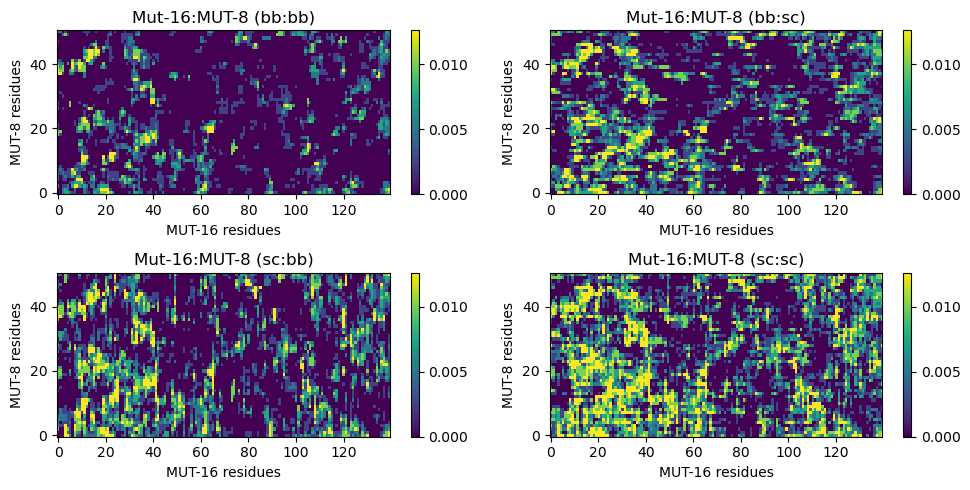

In [34]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Plot each matrix
cax1 = axs[0, 0].imshow(contact_matrix_bb_bb.T, cmap='viridis', interpolation='nearest', aspect='auto')
axs[0, 0].set_title('Mut-16:MUT-8 (bb:bb)')
fig.colorbar(cax1, ax=axs[0, 0])
axs[0, 0].invert_yaxis()  # Invert the y-axis

cax2 = axs[0, 1].imshow(contact_matrix_bb_sc.T, cmap='viridis', interpolation='nearest', aspect='auto')
axs[0, 1].set_title('Mut-16:MUT-8 (bb:sc)')
fig.colorbar(cax2, ax=axs[0, 1])
axs[0, 1].invert_yaxis()  # Invert the y-axis

cax3 = axs[1, 0].imshow(contact_matrix_sc_bb.T, cmap='viridis', interpolation='nearest', aspect='auto')
axs[1, 0].set_title('Mut-16:MUT-8 (sc:bb)')
fig.colorbar(cax3, ax=axs[1, 0])
axs[1, 0].invert_yaxis()  # Invert the y-axis

cax4 = axs[1, 1].imshow(contact_matrix_sc_sc.T, cmap='viridis', interpolation='nearest', aspect='auto')
axs[1, 1].set_title('Mut-16:MUT-8 (sc:sc)')
fig.colorbar(cax4, ax=axs[1, 1])
axs[1, 1].invert_yaxis()  # Invert the y-axis

# Set common labels
for ax in axs.flat:
    ax.set_xlabel('MUT-16 residues')
    ax.set_ylabel('MUT-8 residues')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [73]:
def residue_residue_contact_map(uni, chain1, chain2, n_res_1, n_res_2, contact_matrix_bb_bb, contact_matrix_bb_sc, contact_matrix_sc_bb, contact_matrix_sc_sc):
    """
    Calculate the residue-residue contact map for bb:bb, bb:sc, sc:bb, sc:sc

    Logic:
    ------
    
    
    Returns
    -------
    residue_residue_bb_bb : np.ndarray
        A binary contact map between backbone of chain1 and backbone of chain2
    residue_residue_bb_sc : np.ndarray
        A binary contact map between backbone of chain1 and side chain of chain2
    residue_residue_sc_bb : np.ndarray
        A binary contact map between side chain of chain1 and backbone of chain2
    residue_residue_sc_sc : np.ndarray
        A binary contact map between side chain of chain1 and side chain of chain2
    """
    # Get the sequence of the MUT16 and MUT8 proteins using MDAnalysis
    all_residues = list(uni.residues.resnames)
    MUT16_residues = all_residues[:n_res_1]
    MUT8_residues = all_residues[n_res_1*chain1:n_res_1*chain1+n_res_2]

    residue_residue_matrix_bb_bb = []
    residue_residue_matrix_bb_sc = []   
    residue_residue_matrix_sc_bb = []
    residue_residue_matrix_sc_sc = []

    # Write a for loop to get the residue-residue contact map for bb:bb, bb:sc, sc:bb, sc:sc

    for i, aa_i in enumerate(MUT16_residues):
        # Initialize the row
        row_bb_bb = []
        row_bb_sc = []
        row_sc_bb = []
        row_sc_sc = []

        for j, aa_j in enumerate(MUT8_residues):
            value_bb_bb = contact_matrix_bb_bb[i, j]
            value_bb_sc = contact_matrix_bb_sc[i, j]
            value_sc_bb = contact_matrix_sc_bb[i, j]
            value_sc_sc = contact_matrix_sc_sc[i, j]

            # Resname and values in one list
            element_bb_bb = [aa_i, aa_j, value_bb_bb]
            element_bb_sc = [aa_i, aa_j, value_bb_sc]
            element_sc_bb = [aa_i, aa_j, value_sc_bb]
            element_sc_sc = [aa_i, aa_j, value_sc_sc]

            # Append the element to the row
            row_bb_bb.append(element_bb_bb)
            row_bb_sc.append(element_bb_sc)
            row_sc_bb.append(element_sc_bb)
            row_sc_sc.append(element_sc_sc)

        # Append the row to the matrix
        residue_residue_matrix_bb_bb.append(row_bb_bb)
        residue_residue_matrix_bb_sc.append(row_bb_sc)
        residue_residue_matrix_sc_bb.append(row_sc_bb)
        residue_residue_matrix_sc_sc.append(row_sc_sc)
        
    residue_residue_matrix_bb_bb = np.array(residue_residue_matrix_bb_bb)
    residue_residue_matrix_bb_sc = np.array(residue_residue_matrix_bb_sc)
    residue_residue_matrix_sc_bb = np.array(residue_residue_matrix_sc_bb)
    residue_residue_matrix_sc_sc = np.array(residue_residue_matrix_sc_sc)

    # Create a dictionary to map amino acid names to indices in the matrix
    aa_dict = {'ALA': 0, 'ARG': 1, 'ASN': 2, 'ASP': 3, 'CYS': 4, 'GLU': 5, 'GLN': 6, 'GLY': 7,
           'HIS': 8, 'ILE': 9, 'LEU': 10, 'LYS': 11, 'MET': 12, 'PHE': 13, 'PRO': 14, 'SER': 15,
           'THR': 16, 'TRP': 17, 'TYR': 18, 'VAL': 19}
    
    # Make the residue-residue contact matrix for bb:bb
    aa_matrix_bb_bb = np.zeros((20, 20), dtype=float)
    aa_matrix_count_bb_bb = np.zeros((20, 20), dtype=int)

    for row in residue_residue_matrix_bb_bb:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = aa_dict[aa_i]
            j = aa_dict[aa_j]
            aa_matrix_bb_bb[i, j] += float(value)
            aa_matrix_bb_bb[j, i] += float(value)
            aa_matrix_count_bb_bb[i, j] += 1
            aa_matrix_count_bb_bb[j, i] += 1
                
    aa_matrix_bb_bb_normalised = np.divide(aa_matrix_bb_bb, aa_matrix_count_bb_bb, out=np.zeros_like(aa_matrix_bb_bb), where=aa_matrix_count_bb_bb!=0)
    aa_matrix_bb_bb_unnormalised = aa_matrix_bb_bb

    # Make the residue-residue contact matrix for bb:sc
    aa_matrix_bb_sc = np.zeros((20, 20), dtype=float)
    aa_matrix_count_bb_sc = np.zeros((20, 20), dtype=int)

    for row in residue_residue_matrix_bb_sc:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = aa_dict[aa_i]
            j = aa_dict[aa_j]
            aa_matrix_bb_sc[i, j] += float(value)
            aa_matrix_bb_sc[j, i] += float(value)
            aa_matrix_count_bb_sc[i, j] += 1
            aa_matrix_count_bb_sc[j, i] += 1
            
    aa_matrix_bb_sc_normalised = np.divide(aa_matrix_bb_sc, aa_matrix_count_bb_sc, out=np.zeros_like(aa_matrix_bb_sc), where=aa_matrix_count_bb_sc!=0)
    aa_matrix_bb_sc_unnormalised = aa_matrix_bb_sc

    # Make the residue-residue contact matrix for sc:bb
    aa_matrix_sc_bb = np.zeros((20, 20), dtype=float)
    aa_matrix_count_sc_bb = np.zeros((20, 20), dtype=int)

    for row in residue_residue_matrix_sc_bb:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = aa_dict[aa_i]
            j = aa_dict[aa_j]
            aa_matrix_sc_bb[i, j] += float(value)
            aa_matrix_sc_bb[j, i] += float(value)
            aa_matrix_count_sc_bb[i, j] += 1
            aa_matrix_count_sc_bb[j, i] += 1
            
    aa_matrix_sc_bb_normalised = np.divide(aa_matrix_sc_bb, aa_matrix_count_sc_bb, out=np.zeros_like(aa_matrix_sc_bb), where=aa_matrix_count_sc_bb!=0)
    aa_matrix_sc_bb_unnormalised = aa_matrix_sc_bb

    # Make the residue-residue contact matrix for sc:sc
    aa_matrix_sc_sc = np.zeros((20, 20), dtype=float)
    aa_matrix_count_sc_sc = np.zeros((20, 20), dtype=int)

    for row in residue_residue_matrix_sc_sc:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = aa_dict[aa_i]
            j = aa_dict[aa_j]
            aa_matrix_sc_sc[i, j] += float(value)
            aa_matrix_sc_sc[j, i] += float(value)
            aa_matrix_count_sc_sc[i, j] += 1
            aa_matrix_count_sc_sc[j, i] += 1
            
    aa_matrix_sc_sc_normalised = np.divide(aa_matrix_sc_sc, aa_matrix_count_sc_sc, out=np.zeros_like(aa_matrix_sc_sc), where=aa_matrix_count_sc_sc!=0)
    aa_matrix_sc_sc_unnormalised = aa_matrix_sc_sc

    return aa_matrix_bb_bb_normalised, aa_matrix_bb_bb_unnormalised, aa_matrix_bb_sc_normalised, aa_matrix_bb_sc_unnormalised, aa_matrix_sc_bb_normalised, aa_matrix_sc_bb_unnormalised, aa_matrix_sc_sc_normalised, aa_matrix_sc_sc_unnormalised


In [74]:
# Calculate the residue-residue contact map for bb:bb, bb:sc, sc:bb, sc:sc
residue_residue_contact_map = residue_residue_contact_map(u, chain1, chain2, n_res_1, n_res_2, contact_matrix_bb_bb, contact_matrix_bb_sc, contact_matrix_sc_bb, contact_matrix_sc_sc)
residue_residue_contact_map_bb_bb_normalised = residue_residue_contact_map[0]
residue_residue_contact_map_bb_bb_unnormalised = residue_residue_contact_map[1]
residue_residue_contact_map_bb_sc_normalised = residue_residue_contact_map[2]
residue_residue_contact_map_bb_sc_unnormalised = residue_residue_contact_map[3]
residue_residue_contact_map_sc_bb_normalised = residue_residue_contact_map[4]
residue_residue_contact_map_sc_bb_unnormalised = residue_residue_contact_map[5]
residue_residue_contact_map_sc_sc_normalised = residue_residue_contact_map[6]
residue_residue_contact_map_sc_sc_unnormalised = residue_residue_contact_map[7]

# Save the residue-residue contact map to a .dat file
np.savetxt("residue_residue_contact_map_bb_bb_normalised.dat", residue_residue_contact_map_bb_bb_normalised)
np.savetxt("residue_residue_contact_map_bb_bb_unnormalised.dat", residue_residue_contact_map_bb_bb_unnormalised)
np.savetxt("residue_residue_contact_map_bb_sc_normalised.dat", residue_residue_contact_map_bb_sc_normalised)
np.savetxt("residue_residue_contact_map_bb_sc_unnormalised.dat", residue_residue_contact_map_bb_sc_unnormalised)
np.savetxt("residue_residue_contact_map_sc_bb_normalised.dat", residue_residue_contact_map_sc_bb_normalised)
np.savetxt("residue_residue_contact_map_sc_bb_unnormalised.dat", residue_residue_contact_map_sc_bb_unnormalised)
np.savetxt("residue_residue_contact_map_sc_sc_normalised.dat", residue_residue_contact_map_sc_sc_normalised)
np.savetxt("residue_residue_contact_map_sc_sc_unnormalised.dat", residue_residue_contact_map_sc_sc_unnormalised)

In [75]:
# Process the matrix before plotting

#Step1: Transpose the matrix
transposed_residue_residue_contact_map_bb_bb_normalised = np.transpose(residue_residue_contact_map_bb_bb_normalised)
transposed_residue_residue_contact_map_bb_bb_unnormalised = np.transpose(residue_residue_contact_map_bb_bb_unnormalised)
transposed_residue_residue_contact_map_bb_sc_normalised = np.transpose(residue_residue_contact_map_bb_sc_normalised)
transposed_residue_residue_contact_map_bb_sc_unnormalised = np.transpose(residue_residue_contact_map_bb_sc_unnormalised)
transposed_residue_residue_contact_map_sc_bb_normalised = np.transpose(residue_residue_contact_map_sc_bb_normalised)
transposed_residue_residue_contact_map_sc_bb_unnormalised = np.transpose(residue_residue_contact_map_sc_bb_unnormalised)
transposed_residue_residue_contact_map_sc_sc_normalised = np.transpose(residue_residue_contact_map_sc_sc_normalised)
transposed_residue_residue_contact_map_sc_sc_unnormalised = np.transpose(residue_residue_contact_map_sc_sc_unnormalised)

#Step2: Flip the matrix along the y-axis
flipped_residue_residue_contact_map_bb_bb_normalised = np.flipud(transposed_residue_residue_contact_map_bb_bb_normalised)
flipped_residue_residue_contact_map_bb_bb_unnormalised = np.flipud(transposed_residue_residue_contact_map_bb_bb_unnormalised)
flipped_residue_residue_contact_map_bb_sc_normalised = np.flipud(transposed_residue_residue_contact_map_bb_sc_normalised)
flipped_residue_residue_contact_map_bb_sc_unnormalised = np.flipud(transposed_residue_residue_contact_map_bb_sc_unnormalised)
flipped_residue_residue_contact_map_sc_bb_normalised = np.flipud(transposed_residue_residue_contact_map_sc_bb_normalised)
flipped_residue_residue_contact_map_sc_bb_unnormalised = np.flipud(transposed_residue_residue_contact_map_sc_bb_unnormalised)
flipped_residue_residue_contact_map_sc_sc_normalised = np.flipud(transposed_residue_residue_contact_map_sc_sc_normalised)
flipped_residue_residue_contact_map_sc_sc_unnormalised = np.flipud(transposed_residue_residue_contact_map_sc_sc_unnormalised)

#Step3: resultant matrix
resultant_residue_residue_contact_map_bb_bb_normalised = flipped_residue_residue_contact_map_bb_bb_normalised
resultant_residue_residue_contact_map_bb_bb_unnormalised = flipped_residue_residue_contact_map_bb_bb_unnormalised
resultant_residue_residue_contact_map_bb_sc_normalised = flipped_residue_residue_contact_map_bb_sc_normalised
resultant_residue_residue_contact_map_bb_sc_unnormalised = flipped_residue_residue_contact_map_bb_sc_unnormalised
resultant_residue_residue_contact_map_sc_bb_normalised = flipped_residue_residue_contact_map_sc_bb_normalised
resultant_residue_residue_contact_map_sc_bb_unnormalised = flipped_residue_residue_contact_map_sc_bb_unnormalised
resultant_residue_residue_contact_map_sc_sc_normalised = flipped_residue_residue_contact_map_sc_sc_normalised
resultant_residue_residue_contact_map_sc_sc_unnormalised = flipped_residue_residue_contact_map_sc_sc_unnormalised

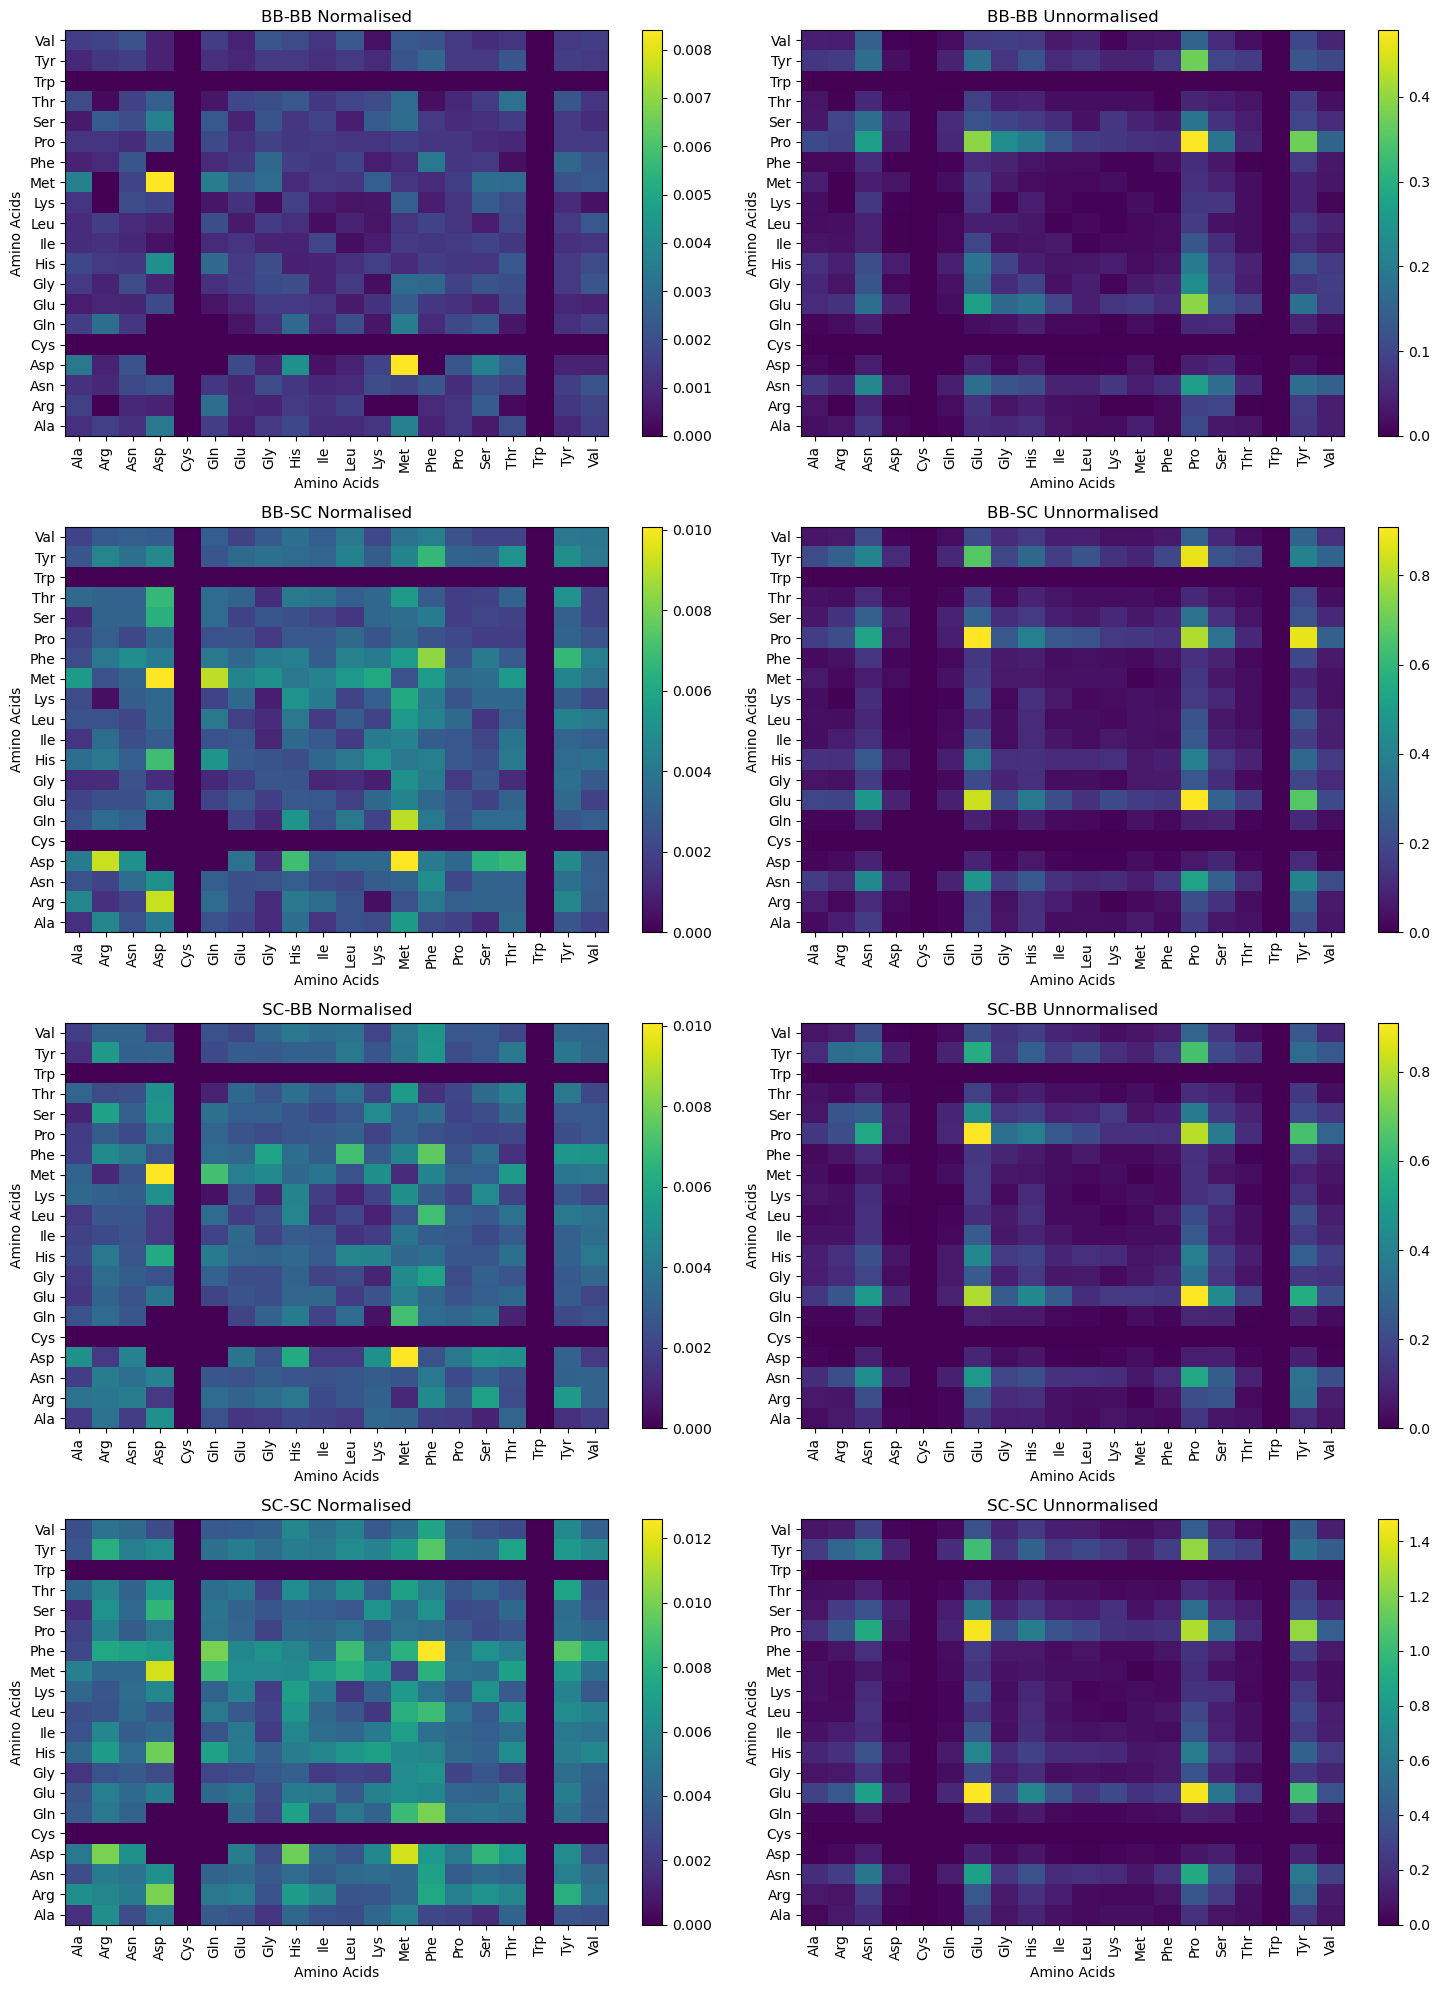

In [76]:
# Define the names of the amino acids in alphabetical order
amino_acids = ['Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Function to plot each matrix with appropriate labels and colorbars
def plot_matrix(ax, matrix, title):
    im = ax.imshow(matrix, cmap='viridis', interpolation='nearest', aspect='auto')
    ax.set_title(title)
    ax.set_xticks(np.arange(20))
    ax.set_xticklabels(amino_acids)
    ax.set_yticks(np.arange(20))
    ax.set_yticklabels(amino_acids[::-1])
    plt.setp(ax.get_xticklabels(), rotation=90)
    fig.colorbar(im, ax=ax)
    #ax.invert_yaxis()

# Plot each matrix
plot_matrix(axs[0, 0], resultant_residue_residue_contact_map_bb_bb_normalised, 'BB-BB Normalised')
plot_matrix(axs[0, 1], resultant_residue_residue_contact_map_bb_bb_unnormalised, 'BB-BB Unnormalised')
plot_matrix(axs[1, 0], resultant_residue_residue_contact_map_bb_sc_normalised, 'BB-SC Normalised')
plot_matrix(axs[1, 1], resultant_residue_residue_contact_map_bb_sc_unnormalised, 'BB-SC Unnormalised')
plot_matrix(axs[2, 0], resultant_residue_residue_contact_map_sc_bb_normalised, 'SC-BB Normalised')
plot_matrix(axs[2, 1], resultant_residue_residue_contact_map_sc_bb_unnormalised, 'SC-BB Unnormalised')
plot_matrix(axs[3, 0], resultant_residue_residue_contact_map_sc_sc_normalised, 'SC-SC Normalised')
plot_matrix(axs[3, 1], resultant_residue_residue_contact_map_sc_sc_unnormalised, 'SC-SC Unnormalised')

# Set common labels for all subplots
for ax in axs.flat:
    ax.set_xlabel('Amino Acids')
    ax.set_ylabel('Amino Acids')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [93]:
def selected_residue_contact_map(uni, chain1, chain2, n_res_1, n_res_2, contact_matrix_bb_bb, contact_matrix_bb_sc, contact_matrix_sc_bb, contact_matrix_sc_sc):
    """
    Calculate the residue-residue contact map for bb:bb, bb:sc, sc:bb, sc:sc

    Logic:
    ------
    
    
    Returns
    -------
    residue_residue_bb_bb : np.ndarray
        A binary contact map between backbone of chain1 and backbone of chain2
    residue_residue_bb_sc : np.ndarray
        A binary contact map between backbone of chain1 and side chain of chain2
    residue_residue_sc_bb : np.ndarray
        A binary contact map between side chain of chain1 and backbone of chain2
    residue_residue_sc_sc : np.ndarray
        A binary contact map between side chain of chain1 and side chain of chain2
    """
    # Get the sequence of the MUT16 and MUT8 proteins using MDAnalysis
    all_residues = list(uni.residues.resnames)
    MUT16_residues = all_residues[:n_res_1]
    MUT8_residues = all_residues[n_res_1 * chain1 : n_res_1 * chain1 + n_res_2]

    residue_residue_matrix_bb_bb = []
    residue_residue_matrix_bb_sc = []   
    residue_residue_matrix_sc_bb = []
    residue_residue_matrix_sc_sc = []

    # Write a for loop to get the residue-residue contact map for bb:bb, bb:sc, sc:bb, sc:sc

    for i, aa_i in enumerate(MUT16_residues):
        # Initialize the row
        row_bb_bb = []
        row_bb_sc = []
        row_sc_bb = []
        row_sc_sc = []

        for j, aa_j in enumerate(MUT8_residues):
            value_bb_bb = contact_matrix_bb_bb[i, j]
            value_bb_sc = contact_matrix_bb_sc[i, j]
            value_sc_bb = contact_matrix_sc_bb[i, j]
            value_sc_sc = contact_matrix_sc_sc[i, j]

            # Resname and values in one list
            element_bb_bb = [aa_i, aa_j, value_bb_bb]
            element_bb_sc = [aa_i, aa_j, value_bb_sc]
            element_sc_bb = [aa_i, aa_j, value_sc_bb]
            element_sc_sc = [aa_i, aa_j, value_sc_sc]

            # Append the element to the row
            row_bb_bb.append(element_bb_bb)
            row_bb_sc.append(element_bb_sc)
            row_sc_bb.append(element_sc_bb)
            row_sc_sc.append(element_sc_sc)

        # Append the row to the matrix
        residue_residue_matrix_bb_bb.append(row_bb_bb)
        residue_residue_matrix_bb_sc.append(row_bb_sc)
        residue_residue_matrix_sc_bb.append(row_sc_bb)
        residue_residue_matrix_sc_sc.append(row_sc_sc)

    residue_residue_matrix_bb_bb = np.array(residue_residue_matrix_bb_bb)
    residue_residue_matrix_bb_sc = np.array(residue_residue_matrix_bb_sc)
    residue_residue_matrix_sc_bb = np.array(residue_residue_matrix_sc_bb)
    residue_residue_matrix_sc_sc = np.array(residue_residue_matrix_sc_sc)

    # Dictionary for the selected residues only
    aa_dict = {'SER': 0, 'ARG': 1, 'GLY': 2, 'TYR': 3, 'ASP': 4, 'PRO': 5, 'LYS': 6, 'PHE': 7, 'HIS': 8}

    # Helper function to safely get index
    def get_index(residue):
        return aa_dict.get(residue, -1)  # Return -1 if residue is not found

    # Make the residue-residue contact matrix for bb:bb
    aa_matrix_bb_bb = np.zeros((9, 9), dtype=float)
    aa_matrix_count_bb_bb = np.zeros((9, 9), dtype=int)

    for row in residue_residue_matrix_bb_bb:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = get_index(aa_i)
            j = get_index(aa_j)
            if i != -1 and j != -1:  # Only process if both residues are in the dictionary
                aa_matrix_bb_bb[i, j] += float(value)
                aa_matrix_bb_bb[j, i] += float(value)
                aa_matrix_count_bb_bb[i, j] += 1
                aa_matrix_count_bb_bb[j, i] += 1

    aa_matrix_bb_bb_normalised = np.divide(aa_matrix_bb_bb, aa_matrix_count_bb_bb, out=np.zeros_like(aa_matrix_bb_bb), where=aa_matrix_count_bb_bb != 0)
    aa_matrix_bb_bb_unnormalised = aa_matrix_bb_bb

    # Make the residue-residue contact matrix for bb:sc
    aa_matrix_bb_sc = np.zeros((9, 9), dtype=float)
    aa_matrix_count_bb_sc = np.zeros((9, 9), dtype=int)

    for row in residue_residue_matrix_bb_sc:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = get_index(aa_i)
            j = get_index(aa_j)
            if i != -1 and j != -1:
                aa_matrix_bb_sc[i, j] += float(value)
                aa_matrix_bb_sc[j, i] += float(value)
                aa_matrix_count_bb_sc[i, j] += 1
                aa_matrix_count_bb_sc[j, i] += 1

    aa_matrix_bb_sc_normalised = np.divide(aa_matrix_bb_sc, aa_matrix_count_bb_sc, out=np.zeros_like(aa_matrix_bb_sc), where=aa_matrix_count_bb_sc != 0)
    aa_matrix_bb_sc_unnormalised = aa_matrix_bb_sc

    # Make the residue-residue contact matrix for sc:bb
    aa_matrix_sc_bb = np.zeros((9, 9), dtype=float)
    aa_matrix_count_sc_bb = np.zeros((9, 9), dtype=int)

    for row in residue_residue_matrix_sc_bb:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = get_index(aa_i)
            j = get_index(aa_j)
            if i != -1 and j != -1:
                aa_matrix_sc_bb[i, j] += float(value)
                aa_matrix_sc_bb[j, i] += float(value)
                aa_matrix_count_sc_bb[i, j] += 1
                aa_matrix_count_sc_bb[j, i] += 1

    aa_matrix_sc_bb_normalised = np.divide(aa_matrix_sc_bb, aa_matrix_count_sc_bb, out=np.zeros_like(aa_matrix_sc_bb), where=aa_matrix_count_sc_bb != 0)
    aa_matrix_sc_bb_unnormalised = aa_matrix_sc_bb

    # Make the residue-residue contact matrix for sc:sc
    aa_matrix_sc_sc = np.zeros((9, 9), dtype=float)
    aa_matrix_count_sc_sc = np.zeros((9, 9), dtype=int)

    for row in residue_residue_matrix_sc_sc:
        for element in row:
            aa_i = element[0]
            aa_j = element[1]
            value = element[2]
            i = get_index(aa_i)
            j = get_index(aa_j)
            if i != -1 and j != -1:
                aa_matrix_sc_sc[i, j] += float(value)
                aa_matrix_sc_sc[j, i] += float(value)
                aa_matrix_count_sc_sc[i, j] += 1
                aa_matrix_count_sc_sc[j, i] += 1

    aa_matrix_sc_sc_normalised = np.divide(aa_matrix_sc_sc, aa_matrix_count_sc_sc, out=np.zeros_like(aa_matrix_sc_sc), where=aa_matrix_count_sc_sc != 0)
    print (aa_matrix_sc_sc_normalised)
    aa_matrix_sc_sc_unnormalised = aa_matrix_sc_sc

    return (
        aa_matrix_bb_bb_normalised, aa_matrix_bb_bb_unnormalised,
        aa_matrix_bb_sc_normalised, aa_matrix_bb_sc_unnormalised,
        aa_matrix_sc_bb_normalised, aa_matrix_sc_bb_unnormalised,
        aa_matrix_sc_sc_normalised, aa_matrix_sc_sc_unnormalised
    )


In [94]:
# Calculate the residue-residue contact map for bb:bb, bb:sc, sc:bb, sc:sc
residue_residue_contact_map = selected_residue_contact_map(u, chain1, chain2, n_res_1, n_res_2, contact_matrix_bb_bb, contact_matrix_bb_sc, contact_matrix_sc_bb, contact_matrix_sc_sc)

# Unpack the results
residue_residue_contact_map_bb_bb_normalised = residue_residue_contact_map[0]
residue_residue_contact_map_bb_bb_unnormalised = residue_residue_contact_map[1]
residue_residue_contact_map_bb_sc_normalised = residue_residue_contact_map[2]
residue_residue_contact_map_bb_sc_unnormalised = residue_residue_contact_map[3]
residue_residue_contact_map_sc_bb_normalised = residue_residue_contact_map[4]
residue_residue_contact_map_sc_bb_unnormalised = residue_residue_contact_map[5]
residue_residue_contact_map_sc_sc_normalised = residue_residue_contact_map[6]
residue_residue_contact_map_sc_sc_unnormalised = residue_residue_contact_map[7]



[[0.00302518 0.00645406 0.00337801 0.00448863 0.0082305  0.00281722
  0.00642297 0.0063611  0.00396095]
 [0.00645406 0.00576107 0.00315099 0.00789021 0.01007559 0.00553091
  0.00335852 0.00756045 0.00697207]
 [0.00337801 0.00315099 0.00346741 0.00450554 0.00294188 0.00257237
  0.00231162 0.00645977 0.00388722]
 [0.00448863 0.00789021 0.00450554 0.00674102 0.00609205 0.00459129
  0.00560259 0.00929884 0.00529943]
 [0.0082305  0.01007559 0.00294188 0.00609205 0.         0.00503918
  0.00589217 0.00671709 0.00980059]
 [0.00281722 0.00553091 0.00257237 0.00459129 0.00503918 0.00362535
  0.00357104 0.00446384 0.00437456]
 [0.00642297 0.00335852 0.00231162 0.00560259 0.00589217 0.00357104
  0.0040302  0.00472844 0.00714104]
 [0.0063611  0.00756045 0.00645977 0.00929884 0.00671709 0.00446384
  0.00472844 0.01260076 0.00573922]
 [0.00396095 0.00697207 0.00388722 0.00529943 0.00980059 0.00437456
  0.00714104 0.00573922 0.00531975]]


In [105]:
# Process the matrix before plotting

#Step1: Transpose the matrix
transposed_residue_residue_contact_map_bb_bb_normalised = np.transpose(residue_residue_contact_map_bb_bb_normalised)
transposed_residue_residue_contact_map_bb_bb_unnormalised = np.transpose(residue_residue_contact_map_bb_bb_unnormalised)
transposed_residue_residue_contact_map_bb_sc_normalised = np.transpose(residue_residue_contact_map_bb_sc_normalised)
transposed_residue_residue_contact_map_bb_sc_unnormalised = np.transpose(residue_residue_contact_map_bb_sc_unnormalised)
transposed_residue_residue_contact_map_sc_bb_normalised = np.transpose(residue_residue_contact_map_sc_bb_normalised)
transposed_residue_residue_contact_map_sc_bb_unnormalised = np.transpose(residue_residue_contact_map_sc_bb_unnormalised)
transposed_residue_residue_contact_map_sc_sc_normalised = np.transpose(residue_residue_contact_map_sc_sc_normalised)
transposed_residue_residue_contact_map_sc_sc_unnormalised = np.transpose(residue_residue_contact_map_sc_sc_unnormalised)

#Step2: Flip the matrix along the y-axis
flipped_residue_residue_contact_map_bb_bb_normalised = np.flipud(transposed_residue_residue_contact_map_bb_bb_normalised)
flipped_residue_residue_contact_map_bb_bb_unnormalised = np.flipud(transposed_residue_residue_contact_map_bb_bb_unnormalised)
flipped_residue_residue_contact_map_bb_sc_normalised = np.flipud(transposed_residue_residue_contact_map_bb_sc_normalised)
flipped_residue_residue_contact_map_bb_sc_unnormalised = np.flipud(transposed_residue_residue_contact_map_bb_sc_unnormalised)
flipped_residue_residue_contact_map_sc_bb_normalised = np.flipud(transposed_residue_residue_contact_map_sc_bb_normalised)
flipped_residue_residue_contact_map_sc_bb_unnormalised = np.flipud(transposed_residue_residue_contact_map_sc_bb_unnormalised)
flipped_residue_residue_contact_map_sc_sc_normalised = np.flipud(transposed_residue_residue_contact_map_sc_sc_normalised)
flipped_residue_residue_contact_map_sc_sc_unnormalised = np.flipud(transposed_residue_residue_contact_map_sc_sc_unnormalised)

#Step3: resultant matrix
resultant_residue_residue_contact_map_bb_bb_normalised = flipped_residue_residue_contact_map_bb_bb_normalised
resultant_residue_residue_contact_map_bb_bb_unnormalised = flipped_residue_residue_contact_map_bb_bb_unnormalised
resultant_residue_residue_contact_map_bb_sc_normalised = flipped_residue_residue_contact_map_bb_sc_normalised
resultant_residue_residue_contact_map_bb_sc_unnormalised = flipped_residue_residue_contact_map_bb_sc_unnormalised
resultant_residue_residue_contact_map_sc_bb_normalised = flipped_residue_residue_contact_map_sc_bb_normalised
resultant_residue_residue_contact_map_sc_bb_unnormalised = flipped_residue_residue_contact_map_sc_bb_unnormalised
resultant_residue_residue_contact_map_sc_sc_normalised = flipped_residue_residue_contact_map_sc_sc_normalised
resultant_residue_residue_contact_map_sc_sc_unnormalised = flipped_residue_residue_contact_map_sc_sc_unnormalised

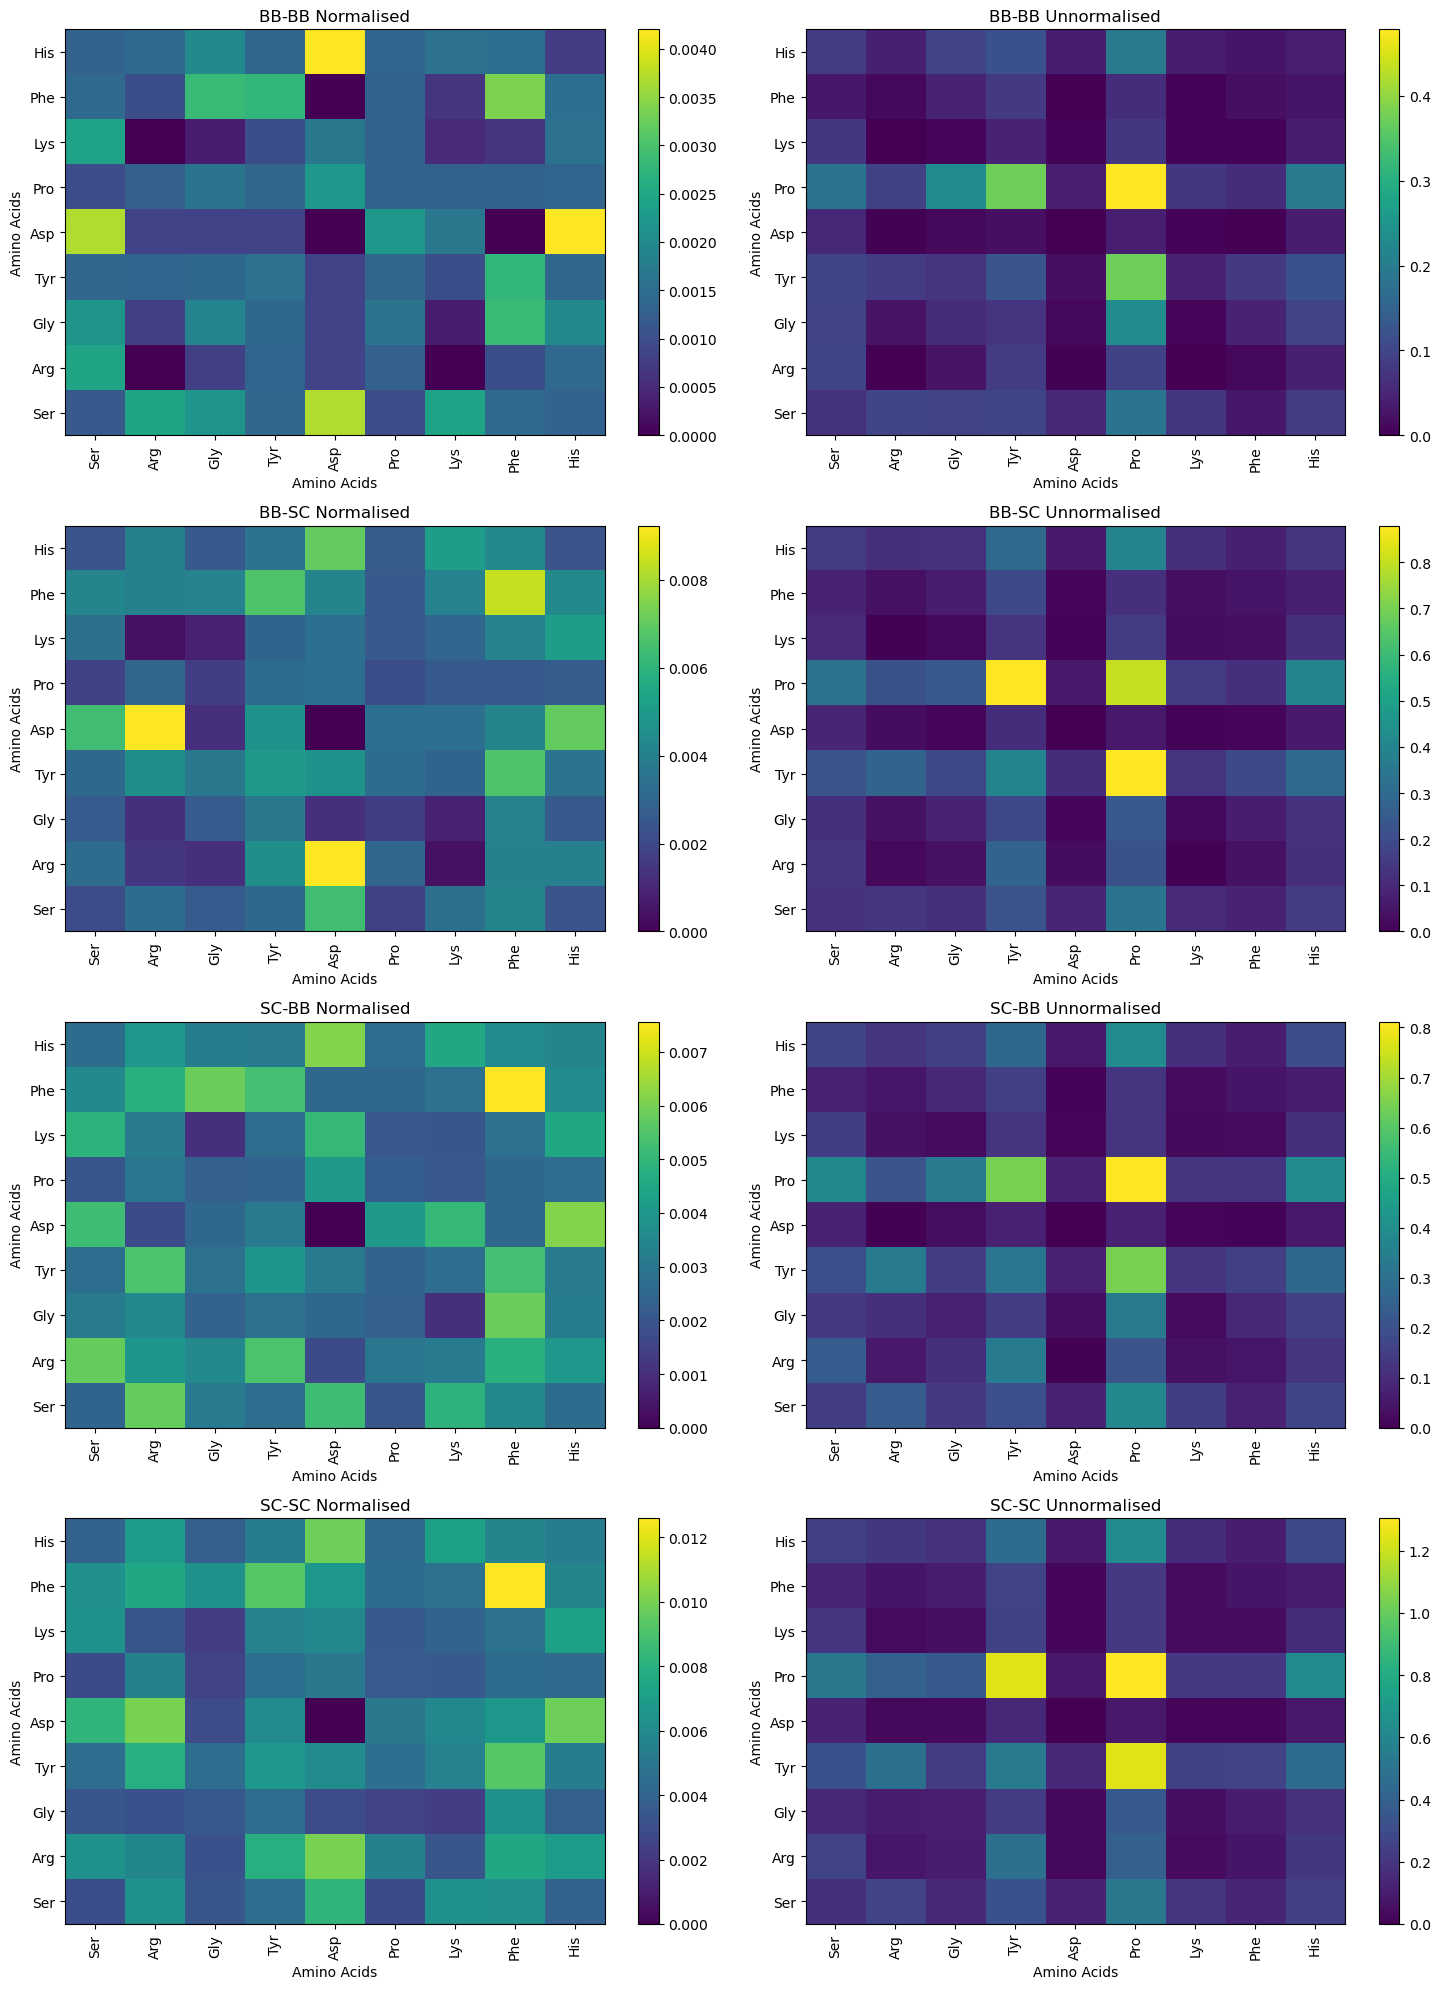

In [106]:
# Define the names of the amino acids in alphabetical order
amino_acids = ['Ser', 'Arg', 'Gly', 'Tyr', 'Asp', 'Pro', 'Lys', 'Phe', 'His']
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Function to plot each matrix with appropriate labels and colorbars
def plot_matrix(ax, matrix, title):
    im = ax.imshow(matrix, cmap='viridis', interpolation='nearest', aspect='auto')
    ax.set_title(title)
    ax.set_xticks(np.arange(9))
    ax.set_xticklabels(amino_acids)
    ax.set_yticks(np.arange(9))
    ax.set_yticklabels(amino_acids[::-1])
    plt.setp(ax.get_xticklabels(), rotation=90)
    fig.colorbar(im, ax=ax)
    #ax.invert_yaxis()

# Plot each matrix
plot_matrix(axs[0, 0], resultant_residue_residue_contact_map_bb_bb_normalised, 'BB-BB Normalised')
plot_matrix(axs[0, 1], resultant_residue_residue_contact_map_bb_bb_unnormalised, 'BB-BB Unnormalised')
plot_matrix(axs[1, 0], resultant_residue_residue_contact_map_bb_sc_normalised, 'BB-SC Normalised')
plot_matrix(axs[1, 1], resultant_residue_residue_contact_map_bb_sc_unnormalised, 'BB-SC Unnormalised')
plot_matrix(axs[2, 0], resultant_residue_residue_contact_map_sc_bb_normalised, 'SC-BB Normalised')
plot_matrix(axs[2, 1], resultant_residue_residue_contact_map_sc_bb_unnormalised, 'SC-BB Unnormalised')
plot_matrix(axs[3, 0], resultant_residue_residue_contact_map_sc_sc_normalised, 'SC-SC Normalised')
plot_matrix(axs[3, 1], resultant_residue_residue_contact_map_sc_sc_unnormalised, 'SC-SC Unnormalised')

# Set common labels for all subplots
for ax in axs.flat:
    ax.set_xlabel('Amino Acids')
    ax.set_ylabel('Amino Acids')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [107]:
print (resultant_residue_residue_contact_map_bb_bb_normalised)

[[0.00131993 0.00142758 0.00199648 0.00139089 0.00420028 0.00136448
  0.0015751  0.00153896 0.00074727]
 [0.00144057 0.00100503 0.00283613 0.00278122 0.         0.00131258
  0.00063128 0.003367   0.00153896]
 [0.00243804 0.         0.00031564 0.00100894 0.00167508 0.00130089
  0.000505   0.00063128 0.0015751 ]
 [0.0009885  0.00129558 0.00160997 0.00138137 0.00224182 0.00132938
  0.00130089 0.00131258 0.00136448]
 [0.00369859 0.00084175 0.00084175 0.00084174 0.         0.00224182
  0.00167508 0.         0.00420028]
 [0.00138158 0.0013632  0.00140488 0.00157445 0.00084174 0.00138137
  0.00100894 0.00278122 0.00139089]
 [0.00217509 0.00078834 0.00189233 0.00140488 0.00084175 0.00160997
  0.00031564 0.00283613 0.00199648]
 [0.00245868 0.         0.00078834 0.0013632  0.00084175 0.00129558
  0.         0.00100503 0.00142758]
 [0.0011776  0.00245868 0.00217509 0.00138158 0.00369859 0.0009885
  0.00243804 0.00144057 0.00131993]]


In [133]:
np.arange(0,5)

array([0, 1, 2, 3, 4])

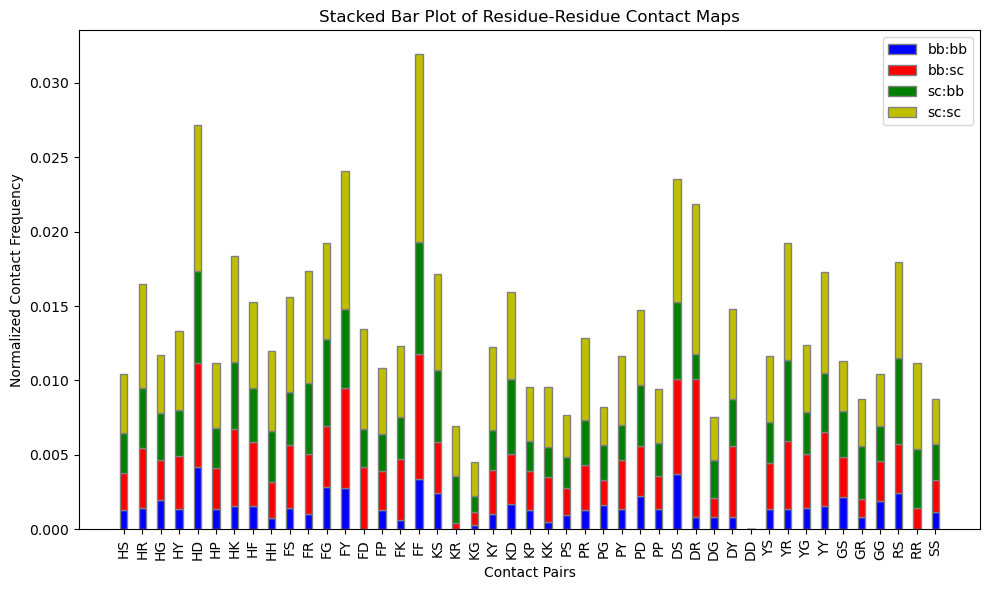

In [156]:

bar_plot_bb_bb_data = []
bar_plot_bb_sc_data = []
bar_plot_sc_bb_data = []
bar_plot_sc_sc_data = []

amino_acids = ['H', 'F', 'K', 'P', 'D', 'Y', 'G', 'R', 'S']

labels = ['HS', 'HR', 'HG', 'HY', 'HD', 'HP', 'HK', 'HF', 'HH', 
 'FS', 'FR', 'FG', 'FY', 'FD', 'FP', 'FK', 'FF', 
 'KS', 'KR', 'KG', 'KY', 'KD', 'KP', 'KK', 
 'PS', 'PR', 'PG', 'PY', 'PD', 'PP', 
 'DS', 'DR', 'DG', 'DY', 'DD', 
 'YS', 'YR', 'YG', 'YY', 
 'GS', 'GR', 'GG', 
 'RS', 'RR', 
 'SS']

x_label = []

for i in np.arange(0,8):
    for j in np.arange(0,8-i+1):
        amino_acids[i]+"_"+amino_acids[8-j]
         


for i in range(9):
    for j in range(9-i):
        bar_plot_bb_bb_data.append(resultant_residue_residue_contact_map_bb_bb_normalised[i, j])
        bar_plot_bb_sc_data.append(resultant_residue_residue_contact_map_bb_sc_normalised[i, j])
        bar_plot_sc_bb_data.append(resultant_residue_residue_contact_map_sc_bb_normalised[i, j])
        bar_plot_sc_sc_data.append(resultant_residue_residue_contact_map_sc_sc_normalised[i, j])

# Convert to numpy arrays for ease of operations
bar_plot_bb_bb_data = np.array(bar_plot_bb_bb_data)
bar_plot_bb_sc_data = np.array(bar_plot_bb_sc_data)
bar_plot_sc_bb_data = np.array(bar_plot_sc_bb_data)
bar_plot_sc_sc_data = np.array(bar_plot_sc_sc_data)

# Plot the histogram
fig, ax = plt.subplots(figsize=(10, 6))
barWidth = 0.4
r = np.arange(len(bar_plot_bb_bb_data))

plt.bar(r, bar_plot_bb_bb_data, color='b', width=barWidth, edgecolor='grey', label='bb:bb')
plt.bar(r, bar_plot_bb_sc_data, bottom=bar_plot_bb_bb_data, color='r', width=barWidth, edgecolor='grey', label='bb:sc')
plt.bar(r, bar_plot_sc_bb_data, bottom=bar_plot_bb_bb_data + bar_plot_bb_sc_data, color='g', width=barWidth, edgecolor='grey', label='sc:bb')
plt.bar(r, bar_plot_sc_sc_data, bottom=bar_plot_bb_bb_data + bar_plot_bb_sc_data + bar_plot_sc_bb_data, color='y', width=barWidth, edgecolor='grey', label='sc:sc')

# Set x-tick labels
plt.xticks([r for r in range(len(labels))], labels, rotation=90)


# Add labels
plt.xlabel('Contact Pairs')
plt.ylabel('Normalized Contact Frequency')
plt.title('Stacked Bar Plot of Residue-Residue Contact Maps')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
